## fMRI Encoding with Textual Representations

This is a tutorial for the Neuroimaging Methods Workshop given by Shaonan Wang. Special thanks to Xiaohan Zhang for proving the raw code in which part of the code is from https://github.com/HuthLab/speechmodeltutorial. If you use the code, please cite:

Zhang, Xiaohan, Shaonan Wang, and Chengqing Zong. How Does the Experimental Setting Affect the Conclusions of Neural Encoding Models?. In Proceedings of the Thirteenth Language Resources and Evaluation Conference, pp. 6397-6404. 2022.

Zhang, Xiaohan, Shaonan Wang, Nan Lin, Jiajun Zhang, and Chengqing Zong. Probing Word Syntactic Representations in the Brain by a Feature Elimination Method. (2022).

In this tutorial you will step through a voxel-wise modeling analysis, which uses textual representations to predict brain activations. The higher the predictation score, the more information of the textual representations (semantics&syntax) is encoded in the brain.

Here we provide some fMRI sample dataset ("story_1.mat, story_2.mat, ..., story_10.mat") and aligned textual representations ("story_1_word2vec_convolved.mat") which can be downloaded from https://drive.google.com/drive/folders/1z52lkYqAXHLV4qenfFUE5yetlgsvdX_3?usp=share_link. For a larger verison of this dataset, please download from : https://openneuro.org/datasets/ds004078. If you use this dataset, please cite:

Wang, Shaonan, Xiaohan Zhang, Jiajun Zhang, and Chengqing Zong. A synchronized multimodal neuroimaging dataset for studying brain language processing. Scientific Data 9, no. 1 (2022): 1-10.

We also provide two scripts: "hrf.py" and "load_nii.py" which can  transform the raw data from https://openneuro.org/datasets/ds004078 to the format used in the this tutorial.

## fMRI encoding framework

In paper "How Does the Experimental Setting Affect the Conclusions of Neural Encoding Models?", we explore the effect of three experimental settings in fMRI encoding framework, including 1) training method, 2) data size, and 3) the statistical significant testing method. We investigate whether and how these different experimental settings affect the results of encoding models.

<div>
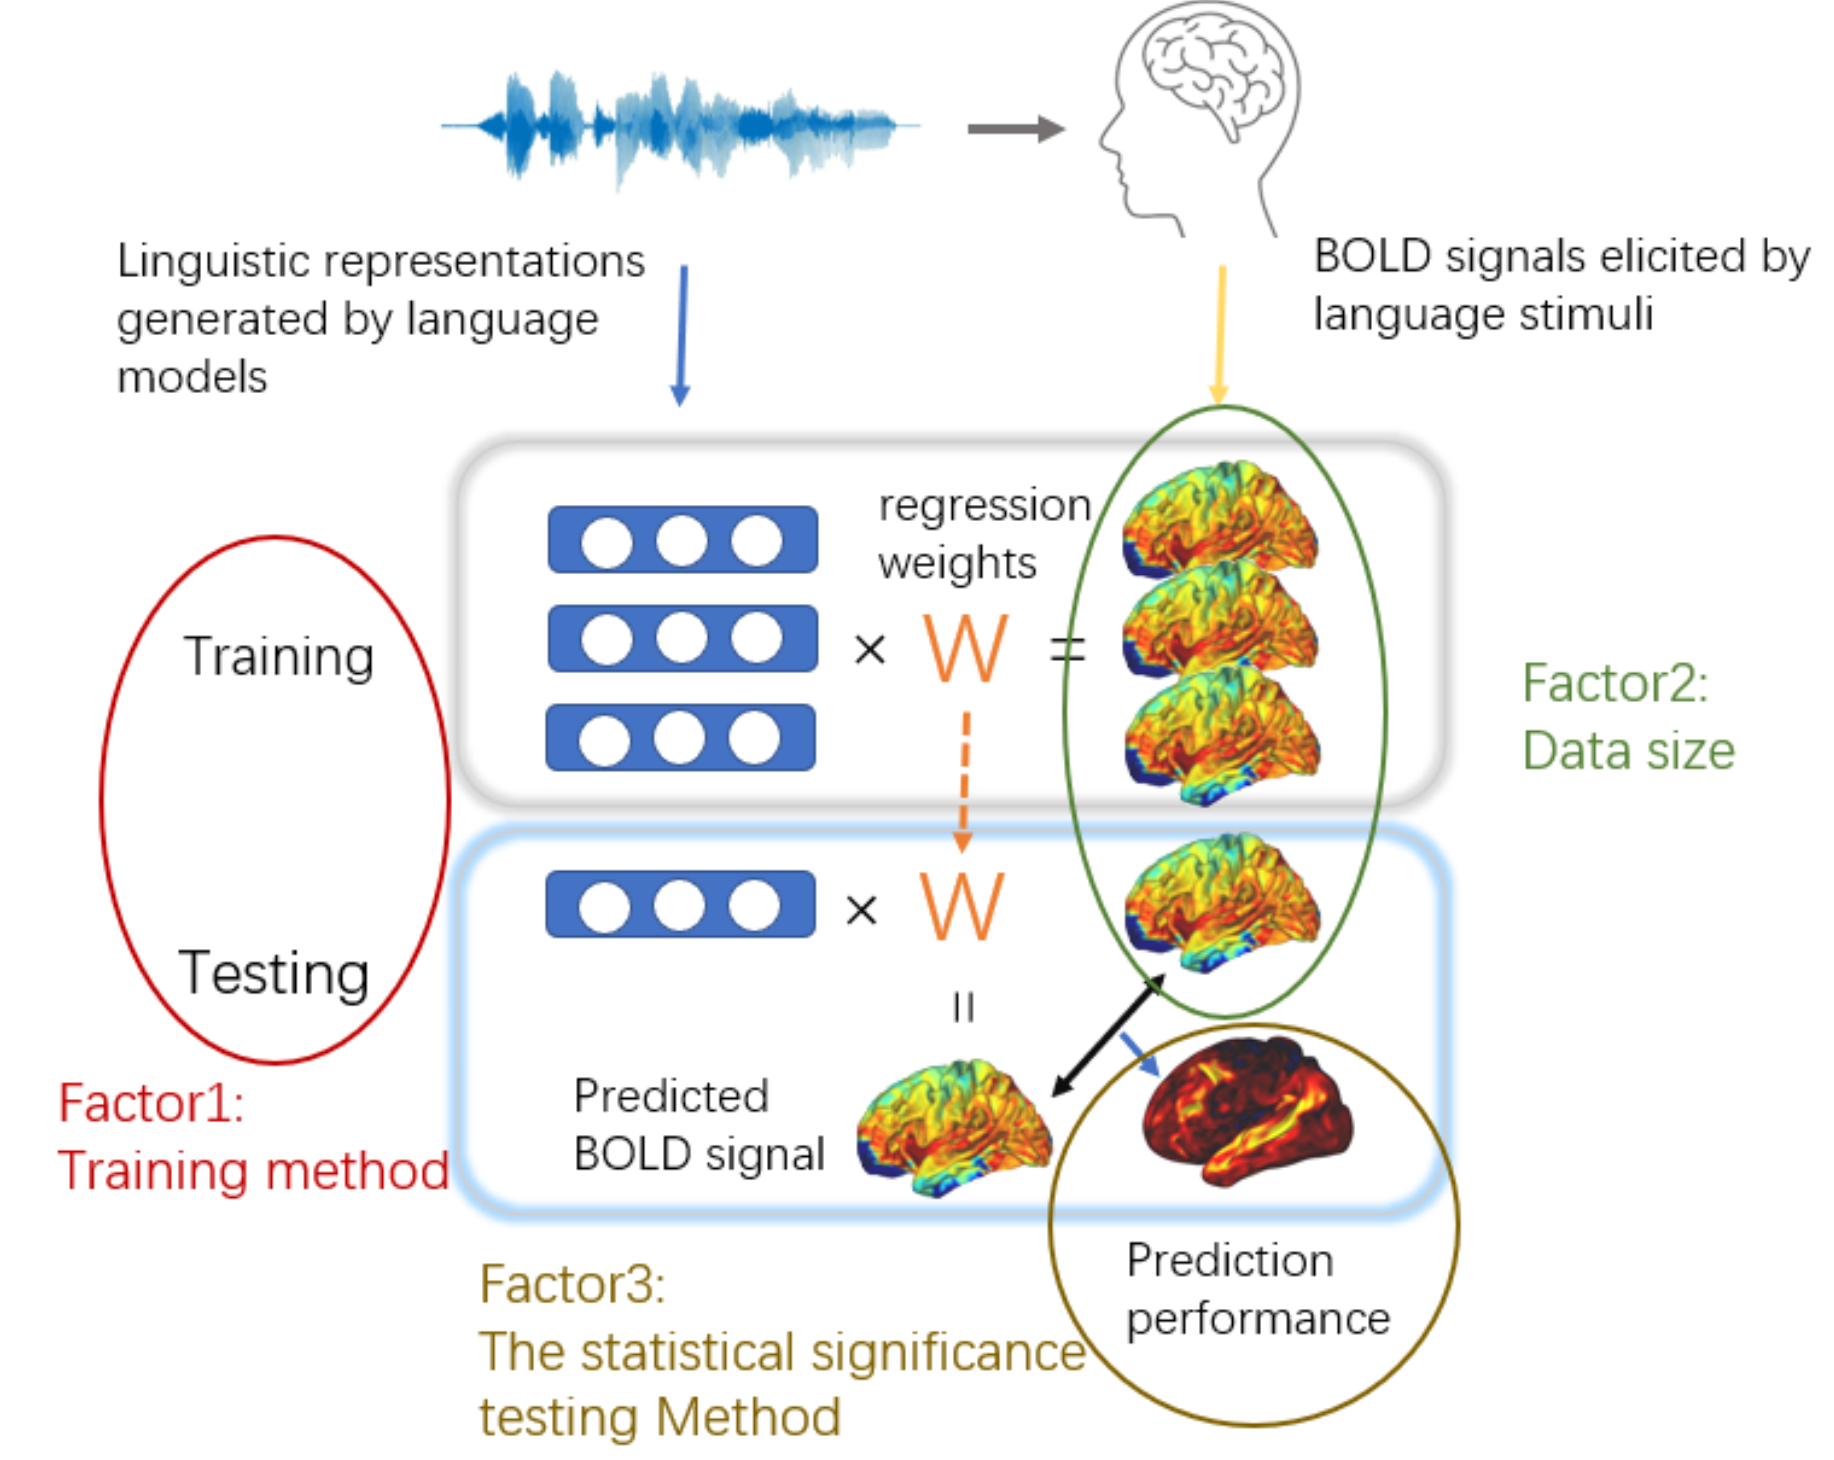
</div>

## Implementation

In the following tutorial, we only show the code of optimal training method and statistical testing with one null hypothesis on a smaller dataset due to computing efficiency.

In [1]:
import h5py
import numpy as np
import random
from tqdm import tqdm
import itertools as itools
from functools import reduce
from statsmodels.stats import multitest
from scipy import stats

zs = lambda v: (v-v.mean(0))/v.std(0) ## z-score function

## Load the sample dataset

In [2]:
sub01_fmri = []
sub02_fmri = []
sub03_fmri = []
feature = []
for sub in range(10):
    sub01_fmri.append(np.array(h5py.File('sub_01_1-10/story_'+str(sub+1)+'.mat', 'r')['fmri_response']))
    sub02_fmri.append(np.array(h5py.File('sub_02_1-10/story_'+str(sub+1)+'.mat', 'r')['fmri_response']))
    sub03_fmri.append(np.array(h5py.File('sub_03_1-10/story_'+str(sub+1)+'.mat', 'r')['fmri_response']))
    feature.append(np.array(h5py.File('word2vec_1-10/story_'+str(sub+1)+'.mat', 'r')['word_feature']).T)
## shape of sub01_fmri: num_story, num_tr, num_voxels


In [11]:
print(len(sub01_fmri))
print(sub01_fmri[0].shape)
print(sub01_fmri[1].shape)
print(feature[0].shape)

10
(568, 59412)
(492, 59412)
(568, 300)


## Visualizing the data

Text(0, 0.5, 'Voxel value')

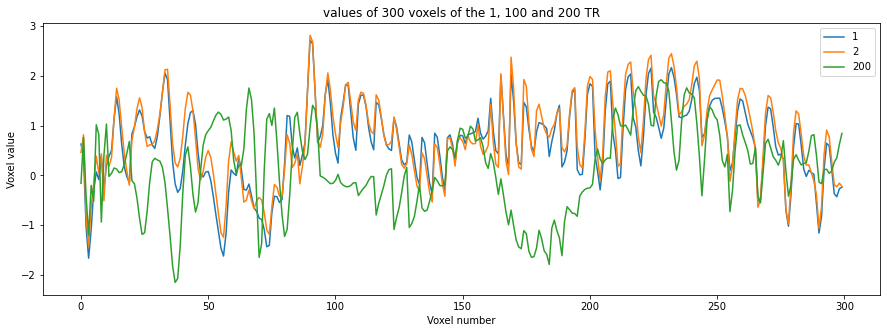

In [6]:
from matplotlib.pyplot import figure, cm
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(sub01_fmri[0][0,0:300], label='1')
ax.plot(sub01_fmri[0][1,0:300], label='2')
ax.plot(sub01_fmri[0][199,0:300], label='200')
ax.legend()
ax.axis("tight")
ax.set_title("values of 300 voxels of the 1, 100 and 200 TR")
ax.set_xlabel("Voxel number")
ax.set_ylabel("Voxel value")

Text(0, 0.5, 'Feature value')

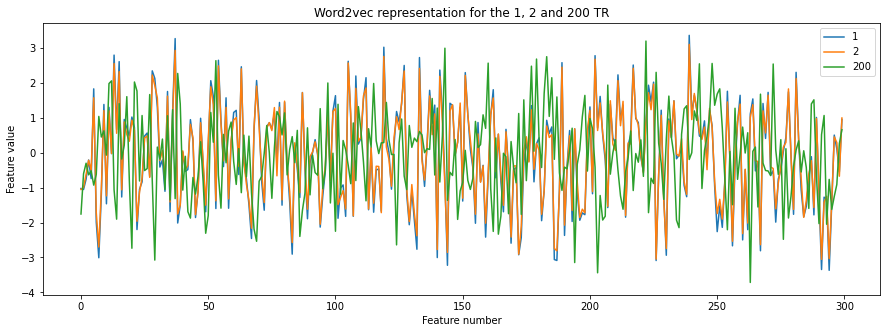

In [7]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(feature[0][0,:], label = '1')
ax.plot(feature[0][1,:], label = '2')
ax.plot(feature[0][199,:], label = '200')
ax.legend()
ax.axis("tight")
ax.set_title("Word2vec representation for the 1, 2 and 200 TR")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")

Text(0, 0.5, 'Feature value')

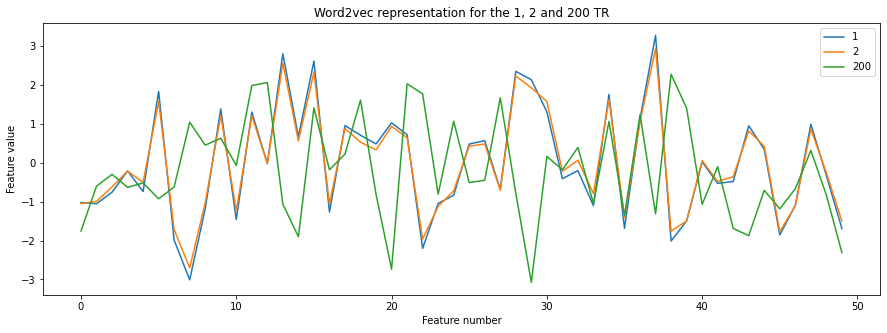

In [14]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(feature[0][0,:50], label = '1')
ax.plot(feature[0][1,:50], label = '2')
ax.plot(feature[0][199,:50], label = '200')
ax.legend()
ax.axis("tight")
ax.set_title("Word2vec representation for the 1, 2 and 200 TR")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")

## Training ridge regression model from textual representations to values of each voxel in fMRI

### Ridge regression
$$E_j(\beta) = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2 + \alpha \sum_i \beta_i^2$$
$$\beta_j = \underset{\beta}{\operatorname{argmin}} E_j(\beta)$$

$\alpha$ controls the strength of the regularization. If $\alpha$ is set to zero, then we get back to exactly the Ordinary Least Squares (OLS) formulation. As $\alpha$ goes to infinity, the regularization forces all the weights to go to zero (in practice this also has the slightly weirder effect of making all the weights independent, as if each feature was regressed separately on the responses).

In [15]:
## ridge regression with blocked cross validation method
## we use a different ridge regression formulation in https://github.com/HuthLab/speechmodeltutorial
## This method improve ridge-regression by re-weighting the singular values of the matrix  before computing its pseudoinverse. 
## It achieves the same results but is extremely efficient because it uses all the linear algebra machinery that computers are so good at to build many models in parallel
def ridge_cv(oRstim, oRresp, alpha, nfolds, chunklen, nchunks, singcutoff=1e-10):
    nresp, nvox = oRresp.shape
    Rcmats = []  ## Save the correlation results on each validation set
    allinds = range(nresp)  ## [0,1,2,...,nresp]
    indchunks = list(zip(*[iter(allinds)] * chunklen)) ## [[0,1,2...chunklen],[45,46...],[91,92,...]...[]]
    random.shuffle(indchunks)
    
    for ind in tqdm(range(nfolds), desc='doing regression...'):
        heldinds = list(itools.chain(*indchunks[ind*nchunks:(ind+1)*nchunks])) ## [0,1,2...chunklen*nchunks]
        notheldinds = list(set(allinds) - set(heldinds))

        Rstim = oRstim[notheldinds, :]
        Pstim = oRstim[heldinds, :]
        Presp = oRresp[heldinds, :]
        Rresp = oRresp[notheldinds, :]

        U, S, V = np.linalg.svd(Rstim)

        ngoodS = np.sum(S > singcutoff) ## Truncate tiny singular values for speed
        U = U[:, :ngoodS]
        S = S[:ngoodS]
        V = V[:, :ngoodS]

        UR = np.dot(U.T, Rresp)
        PVh = np.dot(Pstim, V.T)

        S = S / (S ** 2 + alpha ** 2)  ## Reweight singular vectors by the ridge parameter
        pred = np.dot(S * PVh, UR)
        zPresp = zs(Presp)
        Rcorr = (zPresp * zs(pred)).mean(0)

        Rcorr[np.isnan(Rcorr)] = 0
        Rcmats.append(Rcorr)

    allRcorrs = np.stack(Rcmats, 1)
    wt = reduce(np.dot, [V.T, np.diag(S / (S ** 2 + alpha ** 2)), UR])

    return allRcorrs, wt

### Nested training

The training process contains two loops: 

(1) The outer loop that tests the encoding model on the test set. Specifically, we choose one story as test set in each outer loop and run the outer loop for 10 times so that each story can be the test set in different loops.

(2) The inner 5-fold cross-validation loop that chooses the best hyper-parameters $\alpha$ for ridge regression. Specifically we run a 5-fold cross validation by concatenating the remaining 9 stories together and then splitting them into training and validation set in blocks with length of 45. (Note that block length of 45 equals to 32 seconds which has been shown enough to avoid the influence of information leakage caused by temporal correlation in successive fMRI data)

<div>
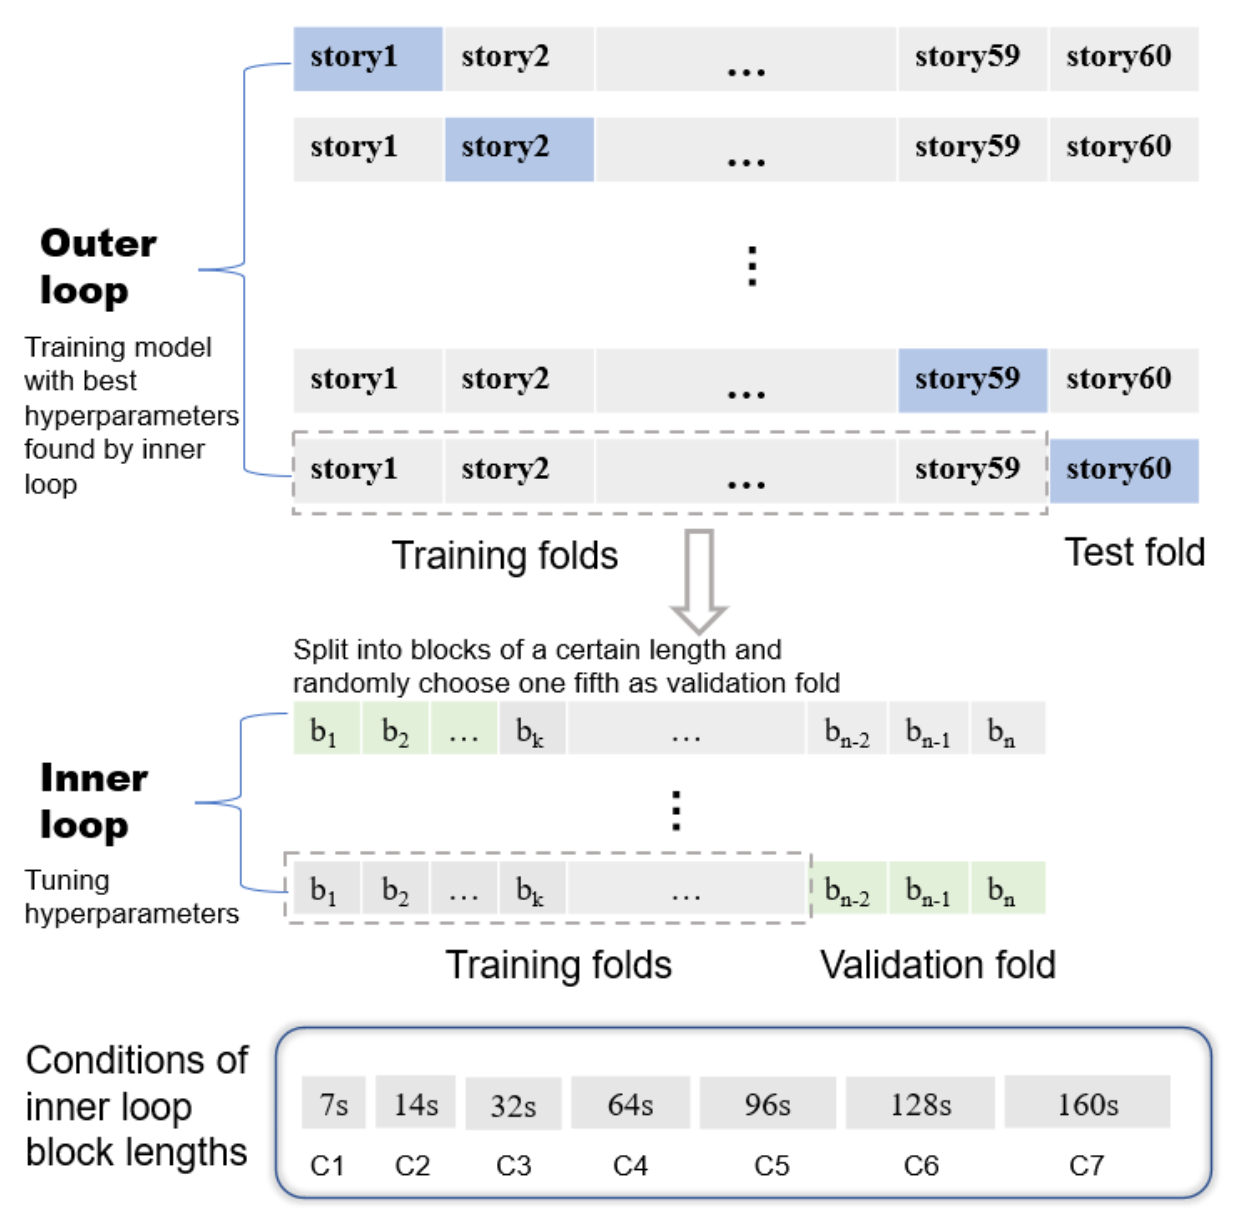
</div>

In [17]:
chunklen = 45  # 32s
num_story = 10
num_subject = 3
sub_corrs = []

for subj in ['sub01', 'sub02', 'sub03']:
    ## ------------------------------ outerloop ------------------------------
    story_corrs = []
    for story_test in range(num_story):
        n = 0
        for story_train in range(num_story):
            if not story_train == story_test:
                n += 1
                if n == 1:
                    train_fmri = locals()[subj + '_fmri'][story_train]
                    train_feature = feature[story_train]
                else:
                    single_fmri = locals()[subj + '_fmri'][story_train]
                    train_fmri = np.concatenate([train_fmri, single_fmri])
                    single_feature = feature[story_train]
                    train_feature = np.concatenate([train_feature, single_feature])
                    
        train_fmri = zs(train_fmri) ## standard score on each voxel
        train_feature = zs(train_feature)
        test_fmri = zs(locals()[subj + '_fmri'][story_test])
        test_feature = zs(feature[story_test])

        # alphas = np.logspace(-3, 3, 40)
        alphas = np.logspace(-2, 2, 5) ## 0.01, 0.1, 1, 10, 100
        chunklen = chunklen
        nfolds = 5  # 5fold cross validation
        nresp, nvox = train_fmri.shape
        nchunks = int(nresp / (chunklen * nfolds))

        # ------------------------------ innerloop ------------------------------
        corrs = []
        wts = []
        for alpha in alphas:
            corr, wt = ridge_cv(train_feature, train_fmri, alpha, nfolds, chunklen, nchunks)
            corrs.append(corr.mean())
            wts.append(wt)
            
        #bestalpha
        bestind = corrs.index(max(corrs))
        print('bestalpha: '+str(alphas[bestind]))
        wt = wts[bestind]

        pred = np.dot(test_feature, wt)
        corrs = (zs(pred)*zs(test_fmri)).mean(0)
        np.save('mid_result/subj'+str(subj)+'_storytest'+str(story_test)+'_corrs.npy', corrs)
        story_corrs.append(corrs)
    sub_corrs.append(np.vstack(story_corrs))
sub_corrs = np.stack(sub_corrs)
print(sub_corrs.shape) # 3, 10, 59412


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.40s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.47s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


bestalpha: 1.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.37s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.40s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.47s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


bestalpha: 10.0
(3, 10, 59412)


### Null hypotheses

Here we adopt null hypotheses of $H_0: r = r_{perm}$ in which $r_{perm}$ is the correlation between the actual fMRI signals and the predicted signal by encoding models trained with permuted stimuli. This hypothesis takes into account that the linear correspondence learned by encoding models may be driven by factors unrelated to linguistic information, thus the $r$ should be greater than the $r_{perm}$ which is the correlation between the actual fMRI signals and the predicted signal by encoding models trained with permuted stimuli.

In [18]:
# H0: permuted stimuli with 100 block random permutation
def block_permute(input_mat, block_len):
    nTRs, _ = input_mat.shape
    x = list(range(nTRs))
    indchunks = list(zip(*[iter(x)] * block_len))
    if nTRs % block_len != 0:
        start = nTRs % block_len
        indchunks.append(x[-start:])
    random.shuffle(indchunks)
    res = list(itools.chain(*indchunks[:]))
    input_mat_permuted = input_mat[res, :]
    return input_mat_permuted

In [19]:
chunklen = 45  # 32s
num_story = 10
num_subject = 3
sub_corrs_null = []

for subj in ['sub01', 'sub02', 'sub03']:
    ## ------------------------------ outerloop ------------------------------
    story_corrs_null = []
    for story_test in range(num_story):
        n = 0
        for story_train in range(num_story):
            if not story_train == story_test:
                n += 1
                if n == 1:
                    train_fmri = locals()[subj + '_fmri'][story_train]
                    train_feature = feature[story_train]
                else:
                    single_fmri = locals()[subj + '_fmri'][story_train]
                    train_fmri = np.concatenate([train_fmri, single_fmri])
                    single_feature = feature[story_train]
                    train_feature = np.concatenate([train_feature, single_feature])
                    
        train_fmri = block_permute(zs(train_fmri), 100)
        train_feature = block_permute(zs(train_feature), 100)
        test_fmri = zs(locals()[subj + '_fmri'][story_test])
        test_feature = zs(feature[story_test])

        # alphas = np.logspace(-3, 3, 40)
        alphas = np.logspace(-2, 2, 5) ## 0.01, 0.1, 1, 10, 100
        chunklen = chunklen
        nfolds = 5  # 5fold cross validation
        nresp, nvox = train_fmri.shape
        nchunks = int(nresp / (chunklen * nfolds))

        # ------------------------------ innerloop ------------------------------
        corrs = []
        wts = []
        for alpha in alphas:
            corr, wt = ridge_cv(train_feature, train_fmri, alpha, nfolds, chunklen, nchunks)
            corrs.append(corr.mean())
            wts.append(wt)
            
        #bestalpha
        bestind = corrs.index(max(corrs))
        print('bestalpha: '+str(alphas[bestind]))
        wt = wts[bestind]

        pred = np.dot(test_feature, wt)
        corrs = (zs(pred)*zs(test_fmri)).mean(0)
        np.save('mid_result/subj'+str(subj)+'_storytest'+str(story_test)+'_null_corrs.npy', corrs)
        story_corrs_null.append(corrs)
    sub_corrs_null.append(np.vstack(story_corrs_null))
sub_corrs_null = np.stack(sub_corrs_null)
print(sub_corrs_null.shape) # 3, 10, 59412


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 1.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.37s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.37s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.50s/it]


bestalpha: 0.01


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.40s/it]


bestalpha: 0.01


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


bestalpha: 100.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


bestalpha: 1.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.40s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.41s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


bestalpha: 0.1


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 1.0


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 0.01


doing regression...: 100%|████████████████████████| 5/5 [00:06<00:00,  1.39s/it]


bestalpha: 10.0


doing regression...: 100%|████████████████████████| 5/5 [00:07<00:00,  1.40s/it]


bestalpha: 0.1
(3, 10, 59412)


## Statistical significant testing

The purpose of significance test is to test whether the prediction accuracy of encoding models is coincidental. Moreover, it should also test whether the prediction accuracy is driven by the mapping irrelevant to stimuli learned by encoding models. 

To test the null hypothesis within our nested cross-validation encoding framework, we compare the Pearson correlations between those computed with encoding models and those computed under the null hypothesis. Hence, significance testing becomes the testing of mean difference between two populations. 

The result is tested both on subject-level and group-level. For subject-level, the correlations of all test stories of one subject are regarded as samples from one population. For group-level, the mean correlations all stories from each subjects are regarded as one sample from the same population. We then test whether the population means of $r$ are significantly larger than that of $r_{perm}$.

In [20]:
def load_corrs(num_subject, num_story, name): #name:corrs or null_corrs
    all_img = []
    for subj in range(sub_amount):
        all_img_sub = []
        for story in range(story_amount):
            single_corr = np.load('subj'+str(subj)+'_storytest'+str(story)+'_'+name+'_.npy')
            all_img_sub.append(single_corr)
        all_img.append(np.vstack(all_img_sub))
    return np.stack(all_img)

## False Discovery Rate (FDR) used to correct p-value to get significant brain voxels
def fdr_bh(p_vals, fdr_q):
    rej, q = multitest.fdrcorrection(p_vals, fdr_q)
    num = rej.sum()
    return rej, num, q

## subject-level significant testing
## t-test: a statistical test that is used to compare the means of two groups. 
## It is most commonly applied when the test statistic would follow a normal distribution 
## if the value of a scaling term in the test statistic were known
## Wilcoxon test: a non-parametric statistical hypothesis test.
## one sample test: test whether the mean of one distribution is significantly above zero).
## two sample test: test whether the means of two populations are significantly different.
def sub_significant_test(all_sub_img, random_img, subs, ttype):
    n_sub, n_story, n_voxel = all_sub_img.shape
    pvals = np.zeros([n_sub, n_voxel])
    qs = np.zeros([n_sub, n_voxel])
    for sub in range(subs):
        for i in range(n_voxel):
            if ttype == 'pair_t':
                f_res = stats.ttest_rel(all_sub_img[sub, :, i], random_img[sub, :, i], alternative='greater')
            elif ttype == 'onesamp_t':
                f_res = stats.ttest_1samp(all_sub_img[sub, :, i], 0, alternative='greater')
            elif ttype == 'onewilx':
                f_res = stats.wilcoxon(all_sub_img[sub, :, i], alternative='greater')
            elif ttype == 'twowilx':
                f_res = stats.wilcoxon(all_sub_img[sub, :, i], random_img[sub, :, i], alternative='greater')
            else:
                print('wrong test type!')
            pvals[sub][i] = f_res[1]
        mask, num, q = fdr_bh(pvals[sub], 0.05)
        print(ttype+' '+str(num)+' of significant voxels out of '+str(n_voxel)+' total voxels') 
        qs[sub] = q
    return qs, pvals

## group-level significant testing
def group_significant_test(all_sub_img, random_img, ttype):
    n_sub, n_story, n_voxel = all_sub_img.shape
    pvals = np.zeros(n_voxel)
    all_sub_img = all_sub_img.mean(1)
    random_img = random_img.mean(1)

    for i in range(n_voxel):
        if ttype == 'pair_t':
            f_res = stats.ttest_rel(all_sub_img[:, i], random_img[:, i], alternative='greater')
        elif ttype == 'onesamp_t':
            f_res = stats.ttest_1samp(all_sub_img[:, i], 0, alternative='greater')
        elif ttype == 'onewilx':
            f_res = stats.wilcoxon(all_sub_img[:, i], alternative='greater')
        elif ttype == 'twowilx':
            f_res = stats.wilcoxon(all_sub_img[:, i], random_img[:, i], alternative='greater')
        else:
            print('wrong test type!')
        pvals[i] = f_res[1]
    mask, num, q = fdr_bh(pvals, 0.05)
    print(ttype+' '+str(num) + ' of significant voxels out of '+str(n_voxel)+' total voxels') 
    return q, pvals

### Voxels in fMRI are considered encoding information of textual representations if $q<0.05/0.01$ 

In [21]:
# all_sub_img = load_corrs(num_subject, num_story, 'corrs')
# random_img = load_corrs(num_subject, num_story, 'null_corrs')
all_sub_img = sub_corrs
random_img = sub_corrs_null
ttypes = ['pair_t', 'onesamp_t', 'onewilx', 'twowilx']
for ttype in ttypes:
    q1, p1 = sub_significant_test(all_sub_img, random_img, 3, ttype)
    q2, p2 = group_significant_test(all_sub_img, random_img, ttype)


pair_t 779 of significant voxels out of 59412 total voxels
pair_t 62 of significant voxels out of 59412 total voxels
pair_t 12 of significant voxels out of 59412 total voxels
pair_t 0 of significant voxels out of 59412 total voxels
onesamp_t 4448 of significant voxels out of 59412 total voxels
onesamp_t 13699 of significant voxels out of 59412 total voxels
onesamp_t 674 of significant voxels out of 59412 total voxels
onesamp_t 1 of significant voxels out of 59412 total voxels
onewilx 3635 of significant voxels out of 59412 total voxels
onewilx 12484 of significant voxels out of 59412 total voxels
onewilx 0 of significant voxels out of 59412 total voxels
onewilx 0 of significant voxels out of 59412 total voxels
twowilx 0 of significant voxels out of 59412 total voxels
twowilx 0 of significant voxels out of 59412 total voxels
twowilx 0 of significant voxels out of 59412 total voxels
twowilx 0 of significant voxels out of 59412 total voxels


## Results from paper "How Does the Experimental Setting Affect the Conclusions of Neural Encoding Models?"

### Effects of different training split settings

The cross-validation training of encoding models using a block-wise form with block length longer than 32s can substantially increase the prediction accuracy.

c1-c7: 7s, 14s, 32s, 64s, 96s, 128s, 160s. c8:average-splitting. c9:stories.

32s is usually taken as the length that an hemodynamic delay lasts.

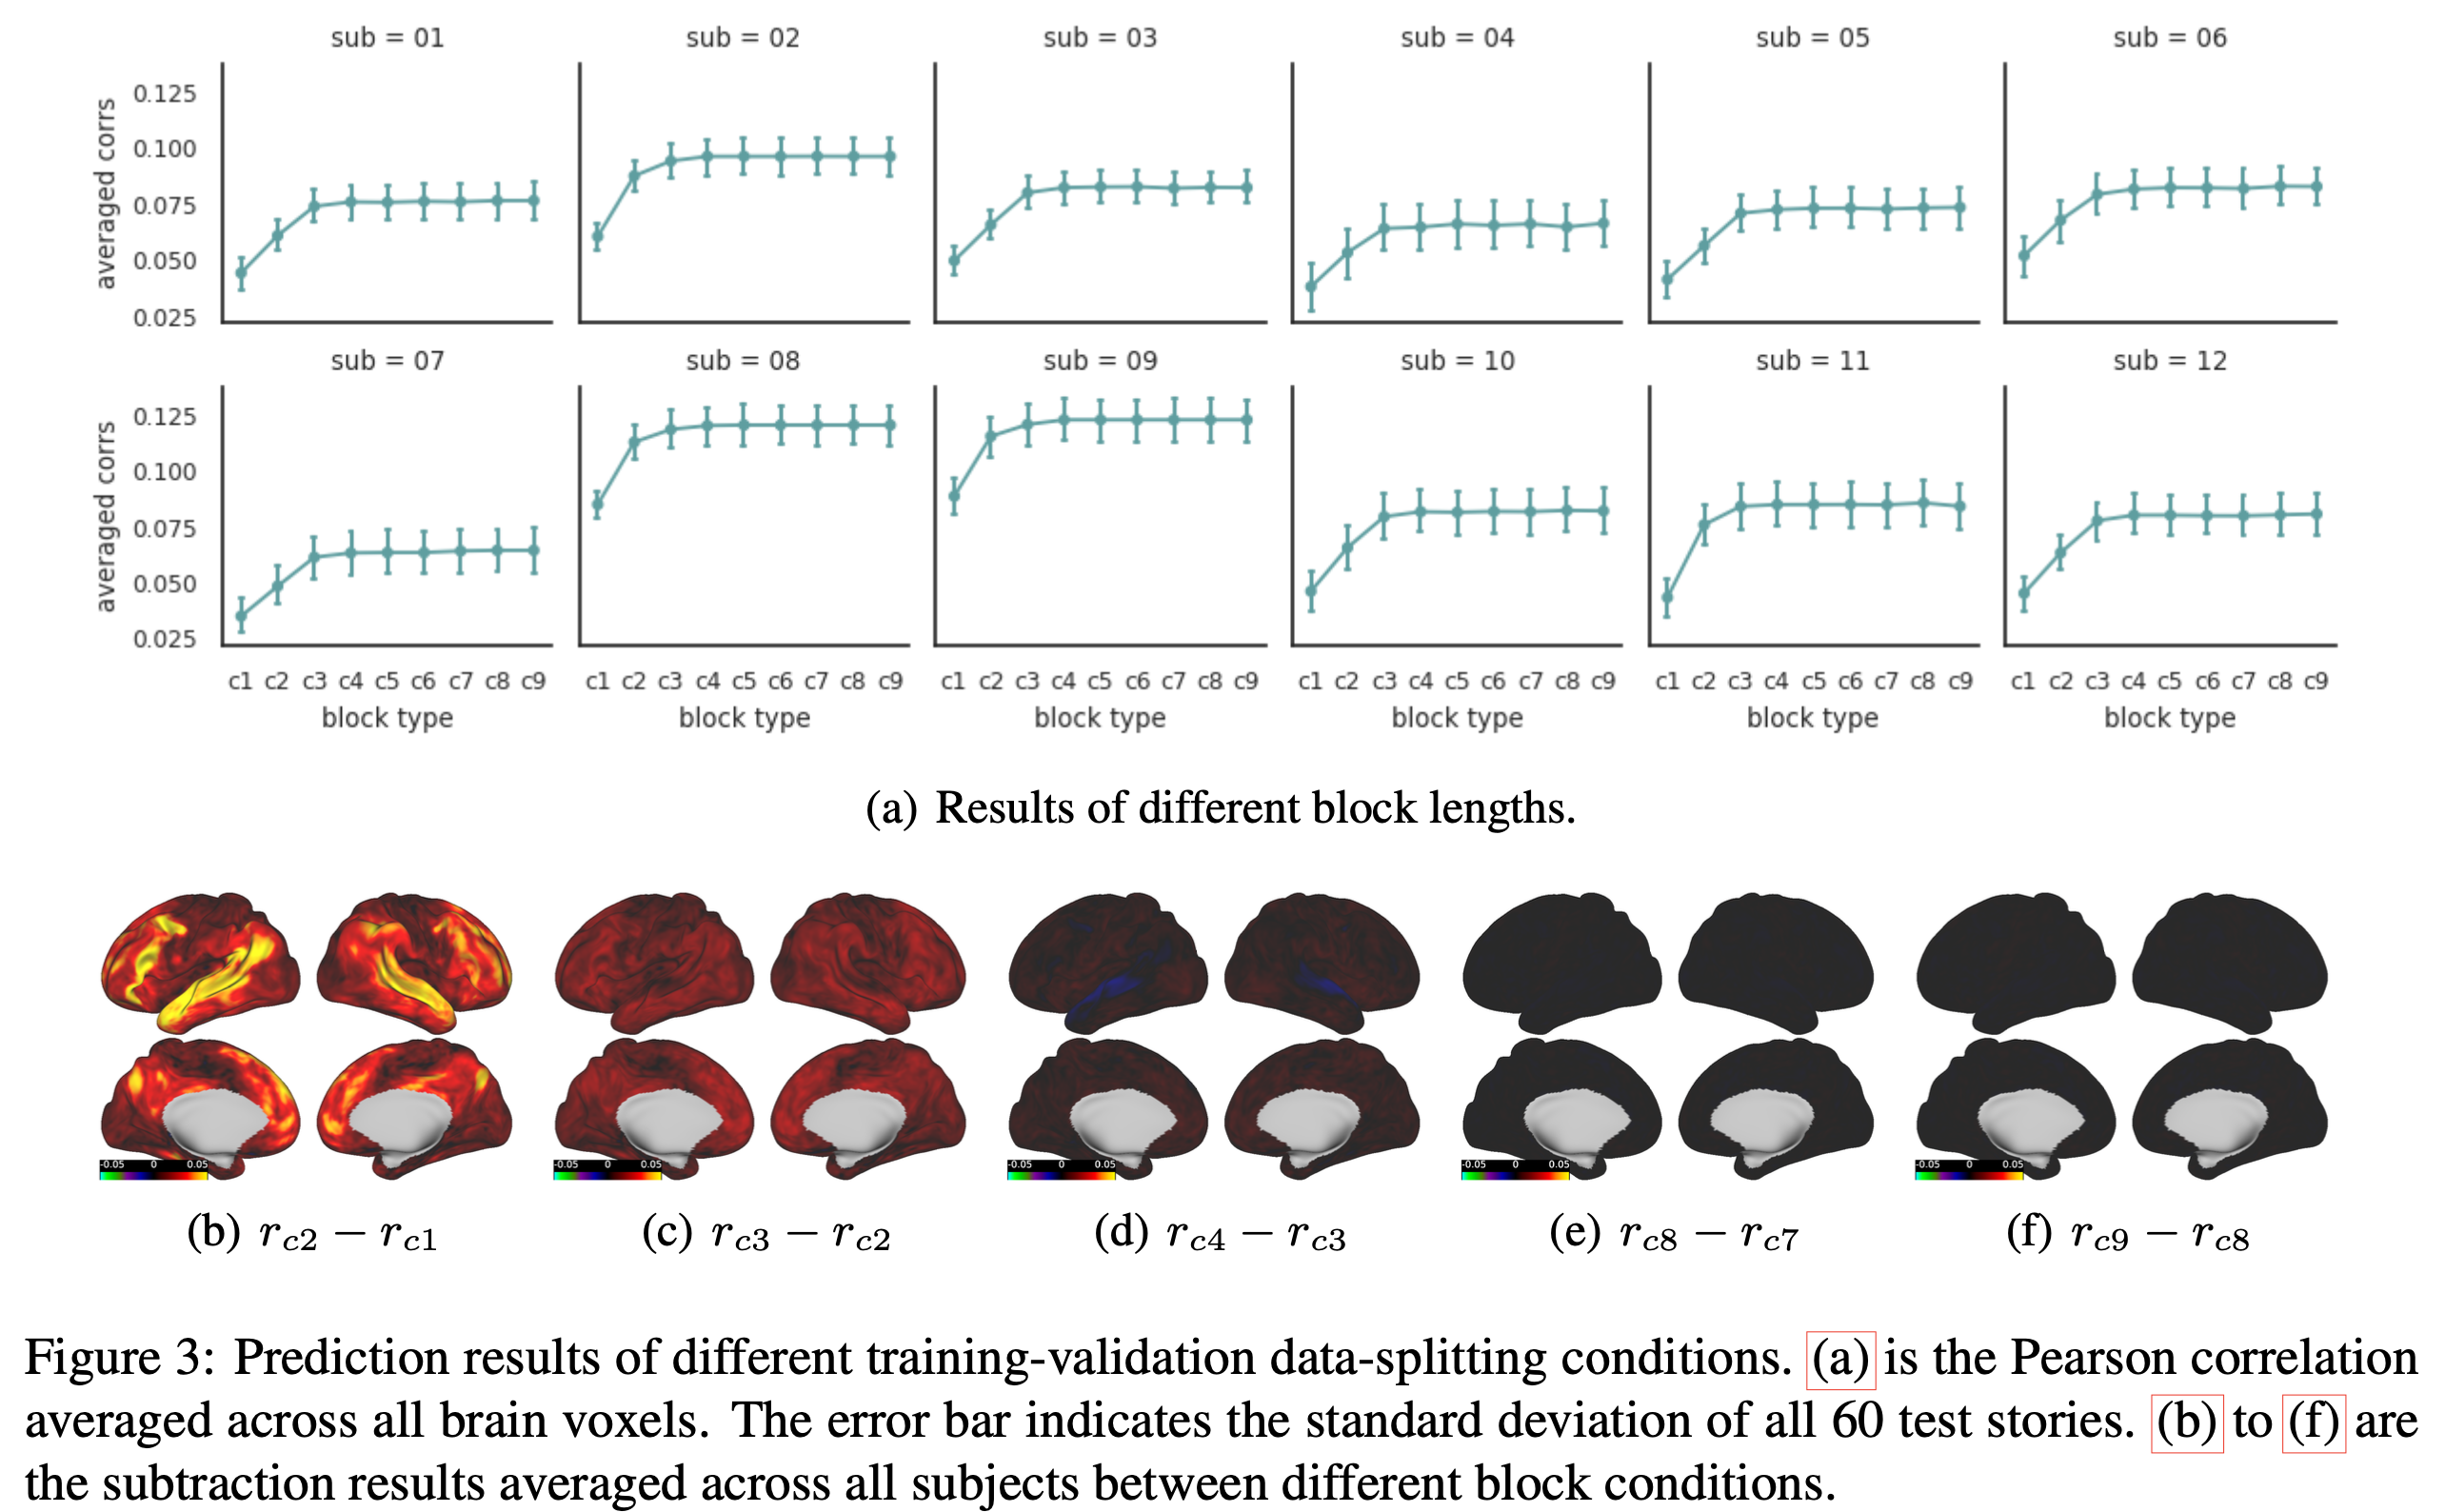

### Effect of different data size

For the linear encoding models, the size of neuroimaging data should be longer than 3 hours (~30 stories) to avoid under-fitting.

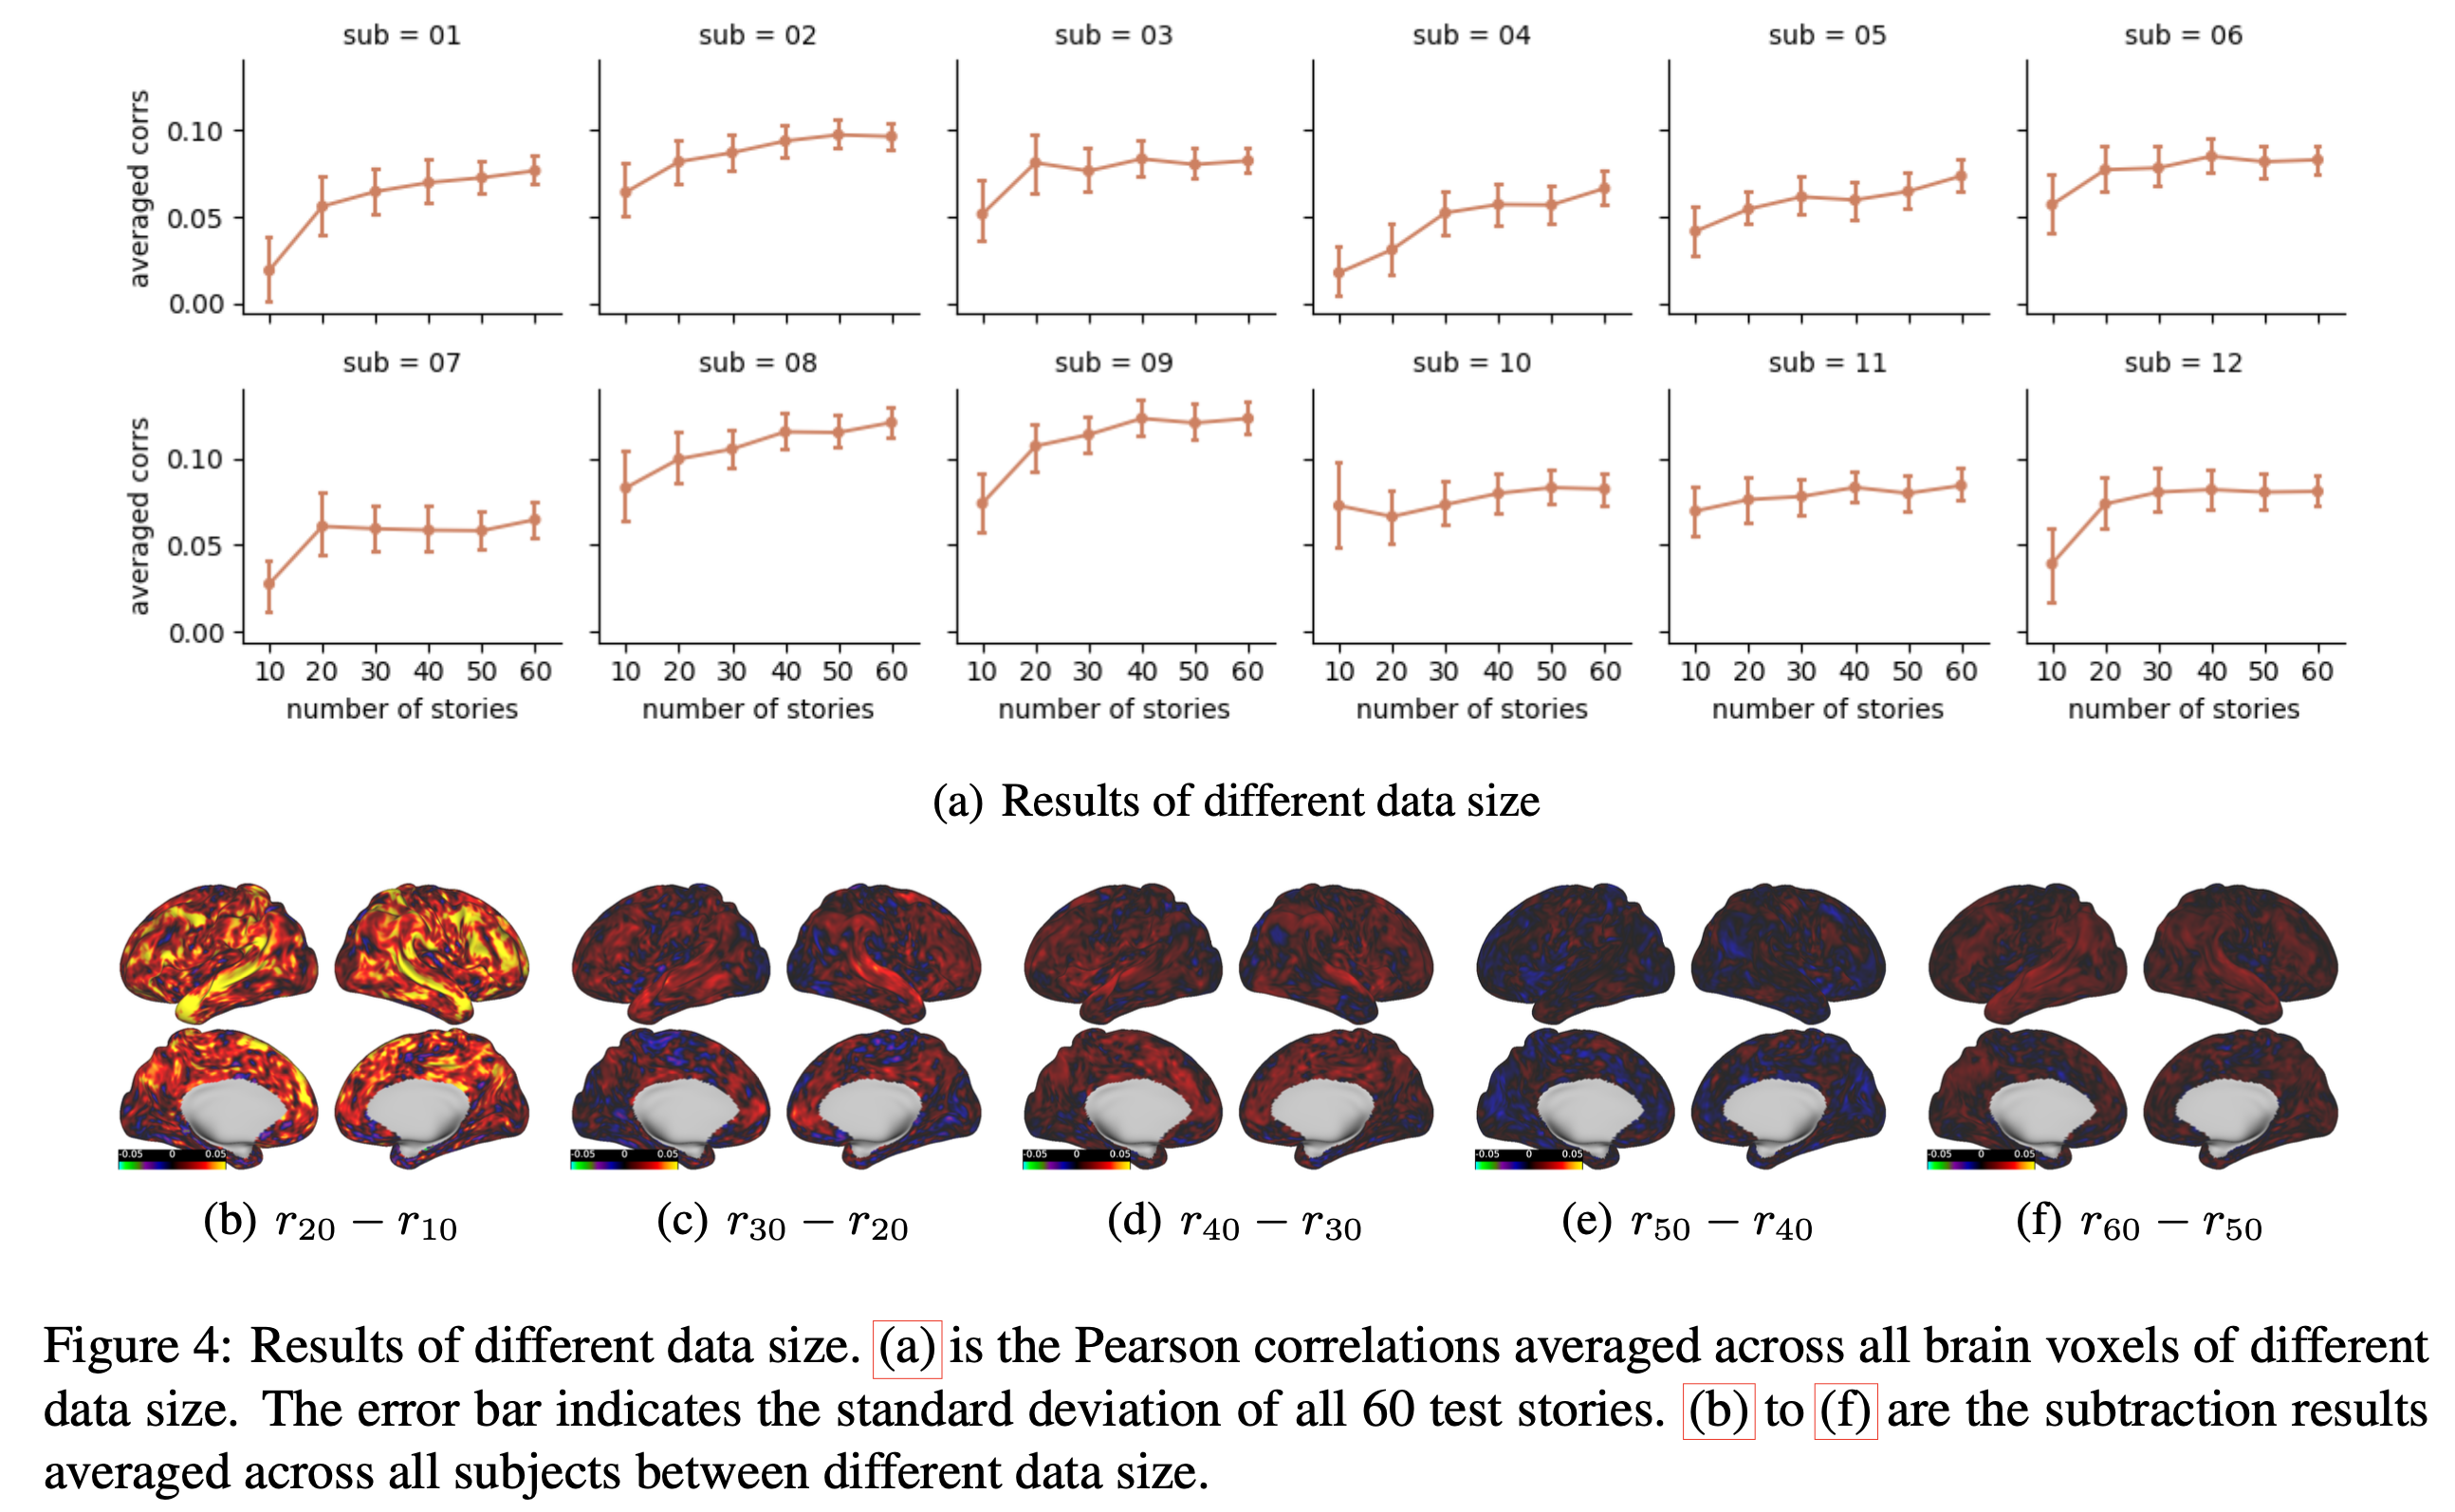

### Effects of different significant testing methd

Considering that encoding models can predict some voxels activation with permuted stimuli or predict their activation in resting state with higher-than-zero accuracy, the null hypothesis in significance testing should be designed carefully to control for these false discoveries.

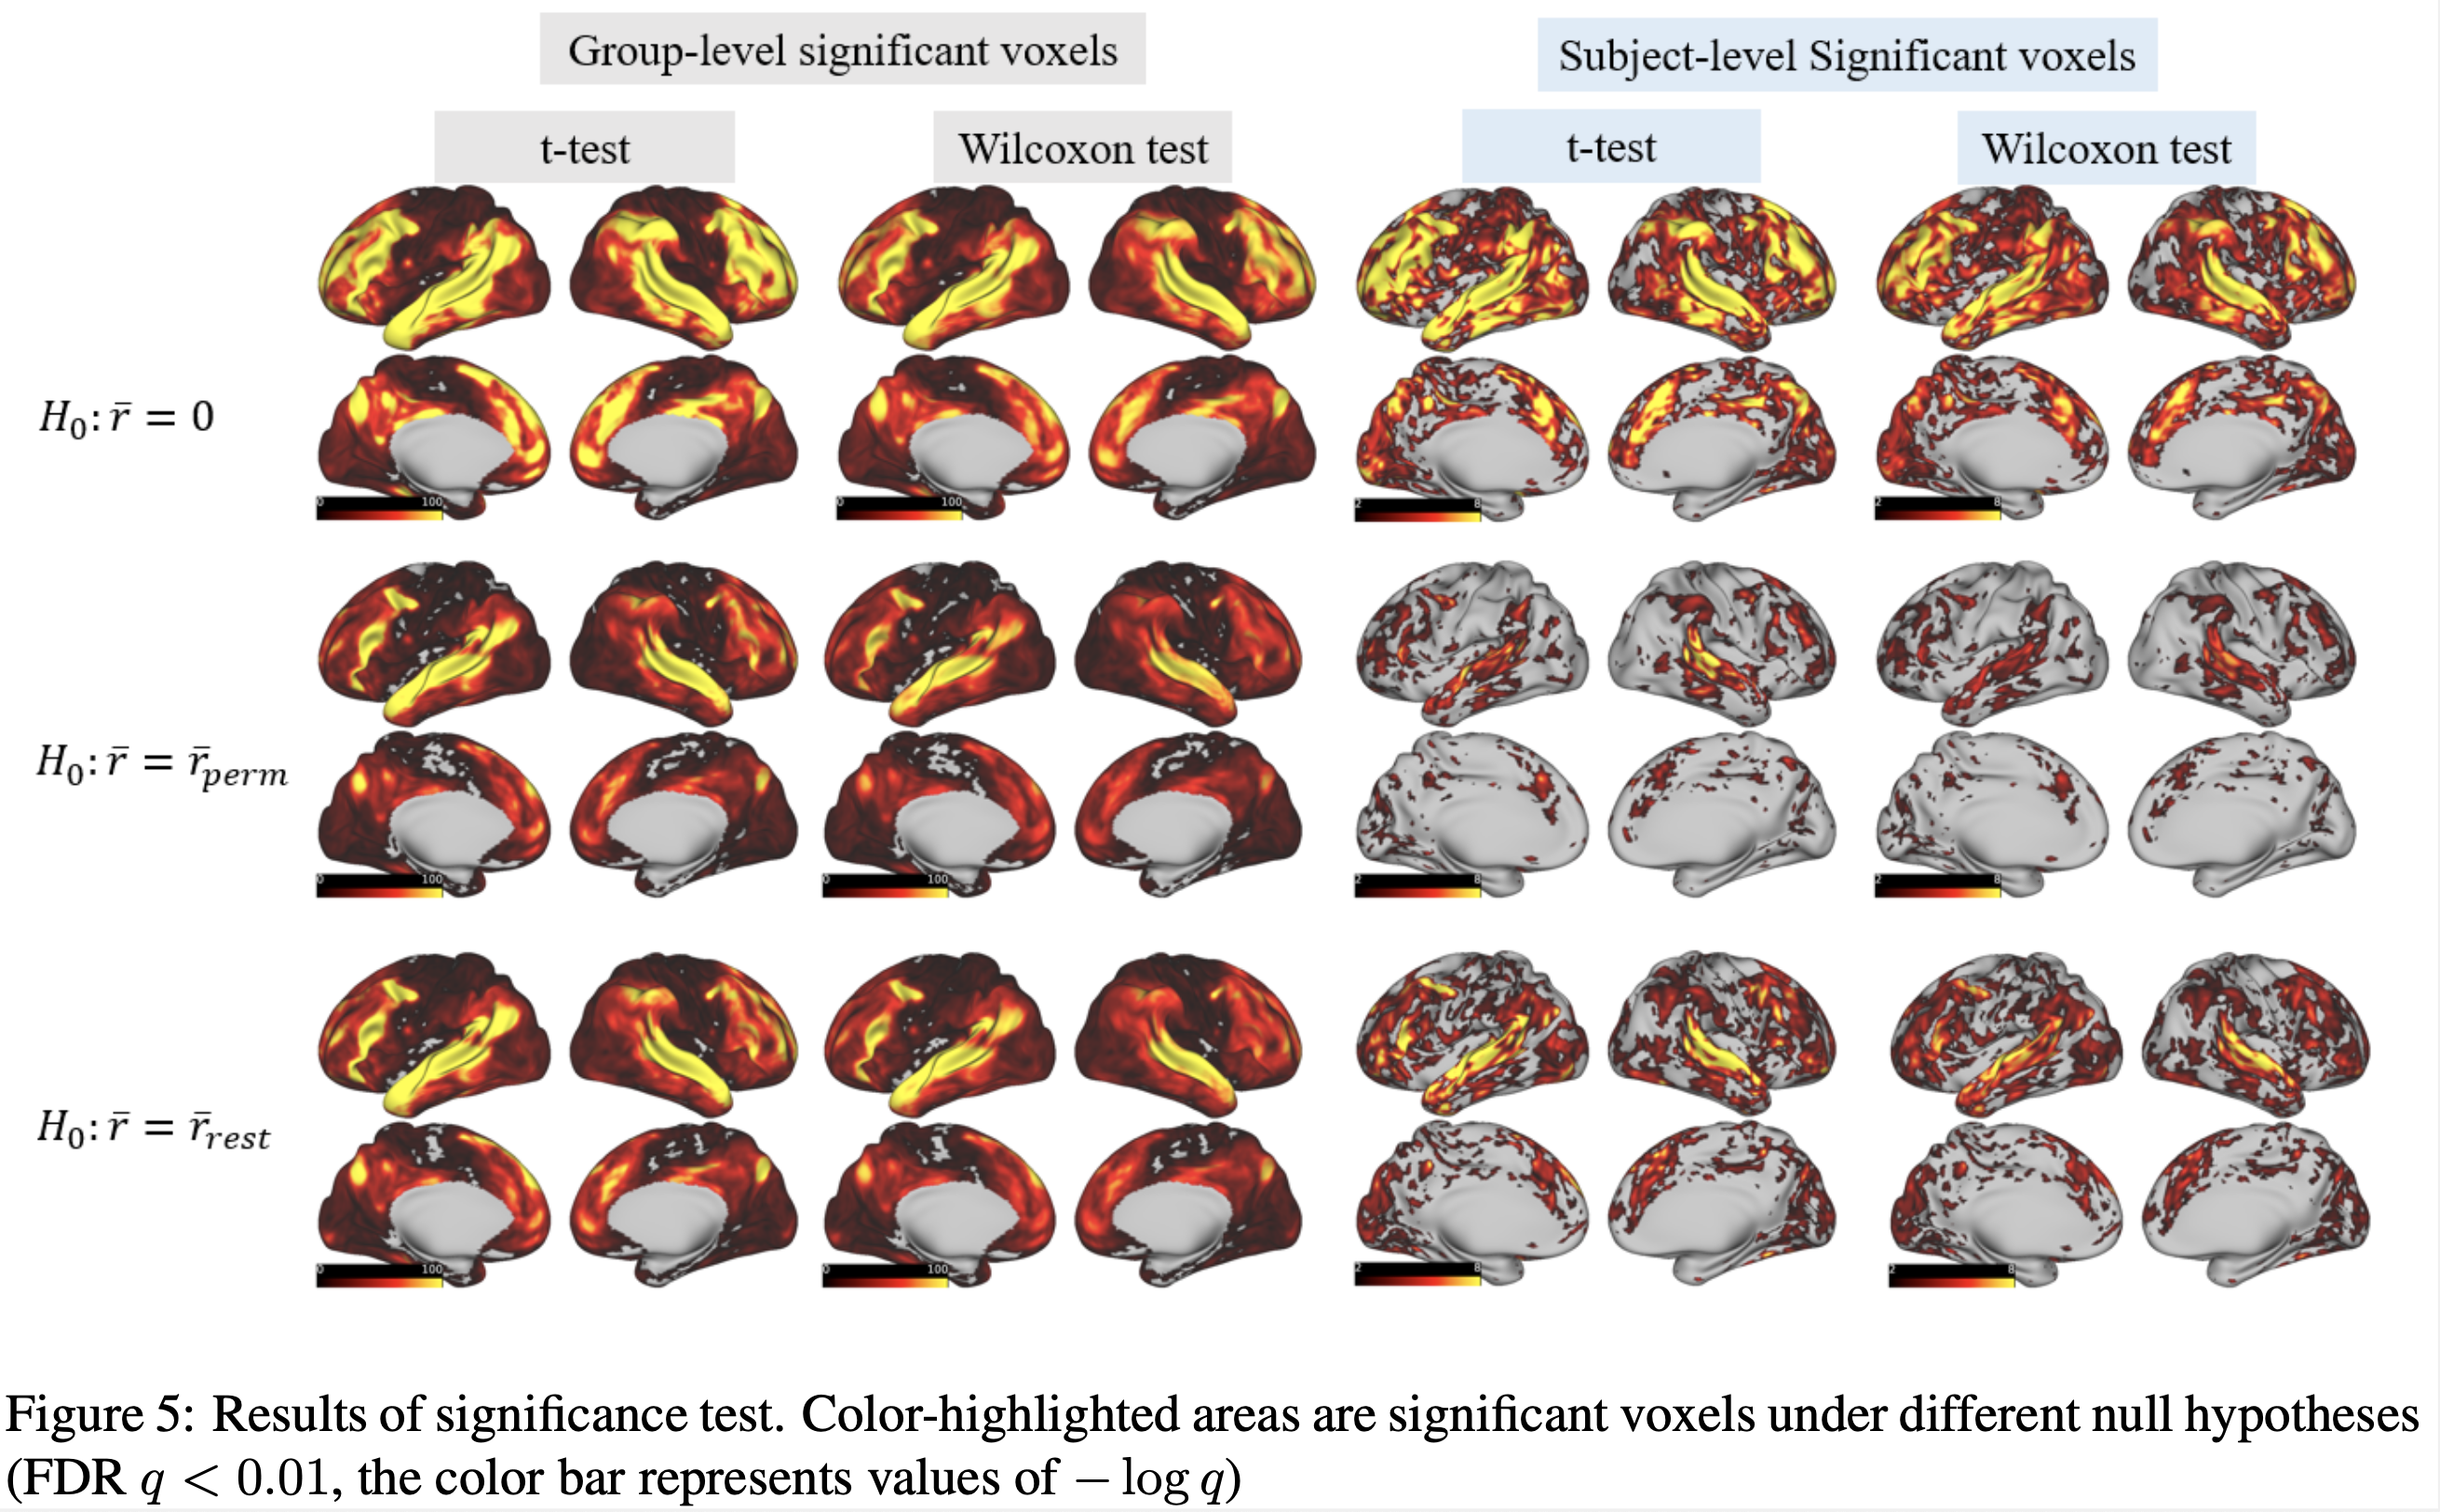